Импорт основных библиотек

In [ ]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn
import torch
from torchaudio.transforms import MelSpectrogram

import math

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Функция отрисовки сигнала

In [ ]:
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

Загрузка датасета

In [ ]:

![ ! -f  waves_yesno.tar.gz ] && wget https://www.openslr.org/resources/1/waves_yesno.tar.gz
# Распаковка
!tar -xvzf waves_yesno.tar.gz

waves_yesno/
waves_yesno/1_0_0_0_0_0_1_1.wav
waves_yesno/1_1_0_0_1_0_1_0.wav
waves_yesno/1_0_1_1_1_1_0_1.wav
waves_yesno/1_1_1_1_0_1_0_0.wav
waves_yesno/0_0_1_1_1_0_0_0.wav
waves_yesno/0_1_1_1_1_1_1_1.wav
waves_yesno/0_1_0_1_1_1_0_0.wav
waves_yesno/1_0_1_1_1_0_1_0.wav
waves_yesno/1_0_0_1_0_1_1_1.wav
waves_yesno/0_0_1_0_1_0_0_0.wav
waves_yesno/0_1_0_1_1_0_1_0.wav
waves_yesno/0_0_1_1_0_1_1_0.wav
waves_yesno/1_0_0_0_1_0_0_1.wav
waves_yesno/1_1_0_1_1_1_1_0.wav
waves_yesno/0_0_1_1_1_1_0_0.wav
waves_yesno/1_1_0_0_1_1_1_0.wav
waves_yesno/0_0_1_1_0_1_1_1.wav
waves_yesno/1_1_0_1_0_1_1_0.wav
waves_yesno/0_1_0_0_0_1_1_0.wav
waves_yesno/0_0_0_1_0_0_0_1.wav
waves_yesno/0_0_1_0_1_0_1_1.wav
waves_yesno/0_0_1_0_0_0_1_0.wav
waves_yesno/1_1_0_1_1_0_0_1.wav
waves_yesno/0_1_1_1_0_1_0_1.wav
waves_yesno/0_1_1_1_0_0_0_0.wav
waves_yesno/README~
waves_yesno/0_1_0_0_0_1_0_0.wav
waves_yesno/1_0_0_0_0_0_0_1.wav
waves_yesno/1_1_0_1_1_0_1_1.wav
waves_yesno/1_1_0_0_0_0_0_1.wav
waves_yesno/1_0_0_0_0_0_0_0.wav
waves_y

Загрузка данных + сплит по трейну/тесту

In [ ]:
def load_yn_dataset():
    X, labels = [], []
    bad_files = set(["0_1_0_1_0_0_0_0"])
    for f in glob('/content/waves_yesno/*.wav'):
        name = os.path.basename(f)[:-4]
        if name in bad_files:
            continue
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels
        
X, Y = load_yn_dataset()

In [ ]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

Функции из 4 л. р.: вычисление мелов, мел-фильтрбанка, MFCC

In [ ]:
def mel(spec):
    return  2595.0 * np.log10(1 + spec / 700)

In [ ]:
def mel_filters_librosa(sr, n_fft, n_mels):
    # функция построения треугольных мел-фильтров в герц-шкале
    # sr - sample rate
    # n_fft - length of the FFT window 
    # n_mels - number of filters
    # return mel filters matrix. [n_mel, n_fft]
    
    weights = np.zeros((n_mels, n_fft // 2 + 1), dtype=np.float)
    frqs = np.fft.fftfreq(n=n_fft // 2 + 1, d=1.0/sr)
    frqs = np.linspace(0, sr / 2.0, n_fft // 2 + 1, endpoint=True)
    max_mel = mel(sr / 2.0)
    mels = np.linspace(0, max_mel, n_mels + 2)
    mels_f = 700.0 * (10.0 ** (mels / 2595.0) - 1.0)
    fdiff = np.diff(mels_f)
    ramps = np.subtract.outer(mels_f, frqs)

    for i in range(n_mels):
      lower = -ramps[i] / fdiff[i]
      upper = ramps[i + 2] / fdiff[i + 1]
      weights[i] = np.maximum(0, np.minimum(lower, upper))
    enorm = 2.0 / (mels_f[2 : n_mels + 2] - mels_f[:n_mels])
    weights *= enorm[:, np.newaxis]
    return weights


In [ ]:
def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_ms=10, n_fbanks=40):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_fbanks - number of filters
    # return fbank matrix [n_fbanks, time]

    n_fft = window_ms * sr // 1000
    hop_length = step_ms * sr // 1000
    power = 2.0

    D2 = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)

    S = np.abs(D2) ** power
    mel_basis = mel_filters_librosa(sr, n_fft=n_fft, n_mels=n_fbanks)
    return np.dot(mel_basis, S)

In [ ]:
def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_ms=10, n_mfcc=13, n_mels = 128):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_mfcc - number of filters
    # return mfcc matrix [n_mfcc, time]
    
    a_min = 1e-10
    s = get_fbanks(wav=wav, sr=sr, window_ms=window_ms, step_ms=step_ms, n_fbanks=n_mels)
    magnitude = s
    log_spec = 10.0 * np.log10(np.maximum(a_min, s))
    log_spec = np.maximum(log_spec, log_spec.max() - 80.0)

    m = np.zeros_like(s)

    for n in np.arange(m.shape[1]):
      m[:,n] = scipy.fftpack.dct(log_spec[:,n], axis=0, type=2, norm='ortho')
    m = m[:n_mfcc,:]

    return m

Задаем параметры для VAD

In [ ]:
sr = 16000
window_ms = 25
step_ms = 10
n_mfcc = 13

Собственно VAD. Считает спектр, потом свертка с окном Хэмминга для сглаживания, сравниваем значения с порогом тишины. Обрезаем/дополняем, если длина не сходится.

In [ ]:
def VAD(signal, sr, window_ms = window_ms, step_ms = step_ms, n_mfcc = n_mfcc, hann_win = 10, threshold = 92):

    mel_spectrum = get_mfcc(signal, sr, window_ms=window_ms, step_ms=step_ms) # вычисление спектра

    mfcc_smooth = scipy.signal.convolve(mel_spectrum[1, :], scipy.signal.windows.hann(hann_win), mode='same') / hann_win # свертка с окном ханна для сглаживания

    step_n = step_ms * sr // 1000
    res = np.intc(mfcc_smooth > threshold)

    if (len(signal) - len(res)) > 0:
            res = np.pad(res, len(signal) - len(res))[len(signal) - len(res):]
    else:
            res = res[:len(signal)]
 
    return res


In [ ]:
train_VA = [VAD(i, sr, window_ms = window_ms, step_ms = step_ms, n_mfcc = n_mfcc, hann_win = 10) for i in X_train]
test_VA = [VAD(i, sr, window_ms = window_ms, step_ms = step_ms, n_mfcc = n_mfcc, hann_win = 10) for i in X_test]

In [ ]:
def test_VAD(VOICE, VA, Y, min_acc=0.95):
    def check_ali(ali, num_words):
        diff = ali[1:]  - ali[:-1]
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() == num_words:
            return -2
        return 0
    
    bad_i = []
    err =0
    for i, (ali, y) in enumerate(zip(VA, Y)):
        assert len(VOICE[i]) == len(ali), "shapes doesn't match"
        if check_ali(ali, len(y)) != 0:
            bad_i.append(i)
            err+=1
    acc = (len(Y) - err)/len(Y)
    print(f"Accuracy {acc}")
    if len(bad_i) >0:
        print(f"ids with error {bad_i}")
    assert acc >= min_acc , f"Accuracy must be >= {min_acc}"
    print("Test passed")

test_VAD(X_train, train_VA, Y_train)
test_VAD(X_test, test_VA, Y_test)
print("VAD ok!")

Accuracy 0.9787234042553191
ids with error [1]
Test passed
Accuracy 1.0
Test passed
VAD ok!


Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки выделеных VAD'ом слов. Или любым другим удобным для вас способом. Добейтесь точности больше 0.95




Создаем датасет

In [ ]:
def make_ds(data, labels, VAD, sr):
    
    X, Y = [], []
    for i, (item, target) in enumerate(zip(data, labels)):
        vad = VAD(item, sr, window_ms, step_ms, n_mfcc)
        mfcc = get_mfcc(item, sr)
        
        idx = []
        for i in range(len(vad) - 1):
            if vad[i] != vad[i + 1]:
                idx.append(i + 1)
        
        for d, i in enumerate(range(0, len(idx), 2)):
            X.append(np.mean(mfcc[:, idx[i]: idx[i + 1]], axis=1))
            Y.append(target[d])
    
    return np.array(X), np.array(Y)


x_train, y_train = make_ds(X_train, Y_train, VAD, sr)
x_test, y_test = make_ds(X_test, Y_test, VAD, sr)

In [ ]:
x_train.shape

(375, 13)

Строим кластеры.

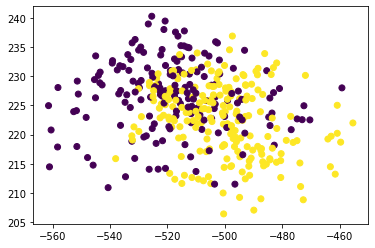

In [ ]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)

Выглядит плохо, попробуем снизить размерность.

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


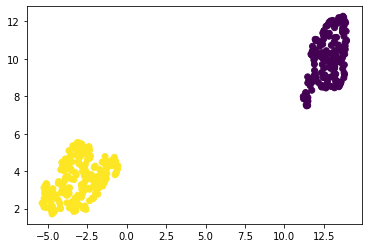

In [ ]:
import umap
reducer = umap.UMAP(n_components=2, random_state=42)
x_umap = reducer.fit_transform(x_train)
plt.scatter(x_umap[:, 0], x_umap[:, 1], c=y_train)

Другое дело.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

Обучаем классификатор

In [ ]:
clf = AdaBoostClassifier(random_state=42) 
clf.fit(x_umap, y_train)

AdaBoostClassifier(random_state=42)

Визуализация скопирована у @kocharyan_x_armen

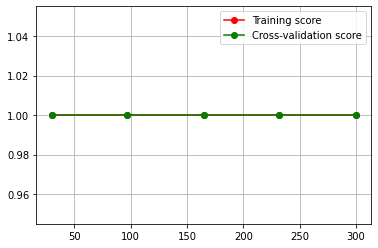

In [ ]:
# Визуализация кривых обучения

train_sizes, train_scores, test_scores = sklearn.model_selection.learning_curve(clf, x_umap, y_train, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
)
plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
)
plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
plt.legend(loc="best")

И посмотрим классификейшен репорты для обучающего и тестового множества

In [ ]:
print(sklearn.metrics.classification_report(y_train, clf.predict(x_umap)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       203

    accuracy                           1.00       375
   macro avg       1.00      1.00      1.00       375
weighted avg       1.00      1.00      1.00       375



In [ ]:
print(sklearn.metrics.classification_report(y_test, clf.predict(reducer.transform(x_test))))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       1.00      0.98      0.99        45

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96

